An exloration around how to improve the prediction of an NBA player's [RPM](https://cornerthreehoops.wordpress.com/2014/04/17/explaining-espns-real-plus-minus/) (Real Plus Minus) metric.  This Kernel was forked from [Noah Gift](https://www.kaggle.com/noahgift), and is based off of his [NBA Player Power Influence And Performance](https://www.kaggle.com/noahgift/nba-player-power-influence-and-performance/notebook) Kernel.


**Contents:**
* Assessing the data.
* Honing in on a key analytical question & initial EDA.
* Creating subsets of data for analysis.
* Expanding EDA.
* Conclusion.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
color = sns.color_palette()
sns.set_style("whitegrid")
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


**Assessing the Data:**

Let's bring in our intial data set, and take a brief look at the variables available.  This should help us formulate a key business question.

In [2]:
## This data set will be our starting point
player_df = pd.read_csv("../input/nba_2017_players_with_salary_wiki_twitter.csv");player_df.head()

,Unnamed: 0,Rk,PLAYER,POSITION,AGE,MP,FG,FGA,FG%,3P,...,DRPM,RPM,WINS_RPM,PIE,PACE,W,SALARY_MILLIONS,PAGEVIEWS,TWITTER_FAVORITE_COUNT,TWITTER_RETWEET_COUNT
0,0,1,Russell Westbrook,PG,28,34.6,10.2,24.0,0.425,2.5,...,-0.47,6.27,17.34,23.0,102.31,46,26.50,4279.0,2130.5,559.0
1,1,2,James Harden,PG,27,36.4,8.3,18.9,0.440,3.2,...,-1.57,4.81,15.54,19.0,102.98,54,26.50,3279.0,969.0,321.5
2,2,4,Anthony Davis,C,23,36.1,10.3,20.3,0.505,0.5,...,3.90,4.35,12.81,19.2,100.19,31,22.12,82.5,368.0,104.0
3,3,6,DeMarcus Cousins,C,26,34.2,9.0,19.9,0.452,1.8,...,0.64,4.20,11.26,17.8,97.11,30,16.96,1625.5,102.0,91.5
4,4,7,Damian Lillard,PG,26,35.9,8.8,19.8,0.444,2.9,...,-1.49,3.14,10.72,15.9,99.68,38,24.33,1830.5,186.5,43.0


**Honing in on a Key Analytical Question:**

There is quite a bit of data here to sift through, and a great deal of analysis has already been completed on this specific data set.  Let's take a fresh approach.

There is a common saying in athletics, that *"Defense Wins Championships"*.  While that may be true, the argument that scoring a point, or a goal, is absolutely required to win any athletic competition.  So how can we justify this statement?  Let's take a stab at answering a key analytical question around this topic:

***Is an NBA player's defensive performance better suited to predict that player's RPM, than their offensive performance?***

Let's find out . . . 

Defense, and offense aside, Is a player's RPM correlated with their total minutes played?

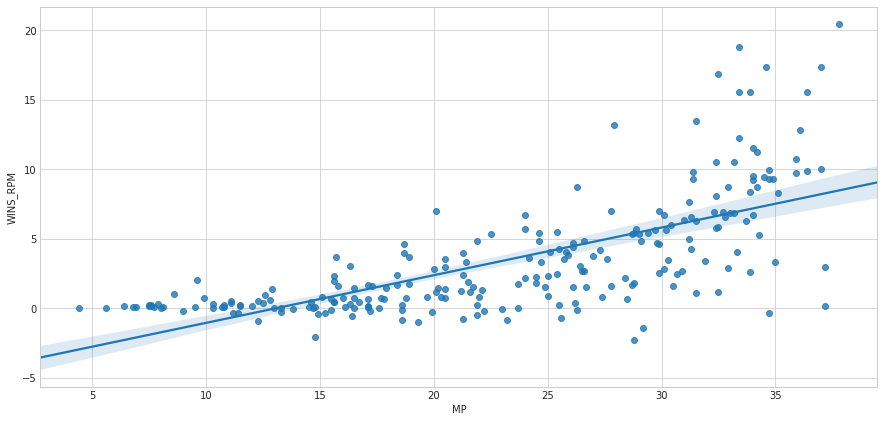

In [15]:
plt.figure(figsize=(15,7))
sns.regplot(x="MP", y="WINS_RPM", data=player_df)

Based off of the regression plot above, it would appear as though there is a correlation between a higher RPM, and more minutes being played.  However there is a tradeoff with an increase in the amount of time a player is on the court.  One could argue that if a player isn't doing so well when they're in the game (a large number of turnovers, missed shots, and fouls), their RPM would actually drop.

Let's assess the strength of this relationship:

In [17]:
minutes = smf.ols('WINS_RPM ~ MP', data=player_df).fit()
print(minutes.summary())

                            OLS Regression Results                            
Dep. Variable:               WINS_RPM   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     221.2
Date:                Fri, 19 Jan 2018   Prob (F-statistic):           8.78e-36
Time:                        18:06:26   Log-Likelihood:                -603.08
No. Observations:                 239   AIC:                             1210.
Df Residuals:                     237   BIC:                             1217.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.4785      0.568     -7.885      0.0

While we have observed a weak positive correlation (Adjusted R-Squared = .481), overall minutes played may not be the best predictor of a player's RPM.*  Let's take one more look at this analysis, with a position overlay.

**Variable transformation could be used from here, to help enhance the linear regression model.*

Is it possible that a player's position *and* minutes played may provide some additional insight?

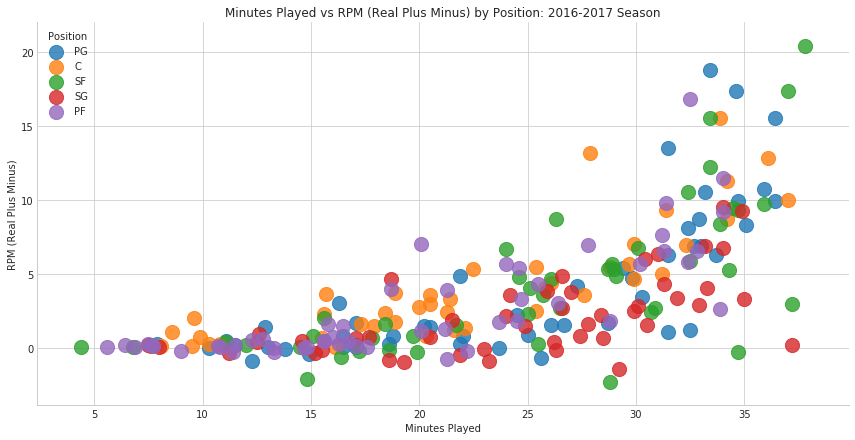

In [18]:
ax = sns.lmplot(x="MP", y="WINS_RPM", data=player_df, hue='POSITION', fit_reg=False, size=6, aspect=2, legend=False, scatter_kws={"s": 200})
ax.set(xlabel='Minutes Played', ylabel='RPM (Real Plus Minus)', title="Minutes Played vs RPM (Real Plus Minus) by Position: 2016-2017 Season")
plt.legend(loc='upper left', title='Position')

Now that we have overlayed a player's position over their minutes played vs their RPM, we can see some very interesting findings:

There are no shooting guards in the upper echelon of player RPMs.
Small forwards and point guards seem to be yielding the highest RPM per minutes played.
There is only one power forward in the most elite group.

Have shooting guards and power forwards been marginalized, when it comes to contributing to a team's win?  It could appear so.

Let's reshift our focus to targeting specific deffensive and offensive statistics related to a player's RPM.

**Creating Subsets of Data for Analysis:**

In [22]:
## Defense
player_df_def = player_df[["DRB","STL","BLK","WINS_RPM"]].copy();player_df_def.head()

,DRB,STL,BLK,WINS_RPM
0,9.0,1.6,0.4,17.34
1,7.0,1.5,0.5,15.54
2,9.5,1.3,2.2,12.81
3,8.9,1.4,1.3,11.26
4,4.3,0.9,0.3,10.72


In [23]:
## Offense
player_df_off = player_df[["eFG%","FT%","ORB","AST","POINTS","WINS_RPM"]].copy()
player_df_off.rename(columns={'eFG%': 'eFG','FT%':'FT'}, inplace=True)
player_df_off.head()

,eFG,FT,ORB,AST,POINTS,WINS_RPM
0,0.476,0.845,1.7,10.4,31.6,17.34
1,0.525,0.847,1.2,11.2,29.1,15.54
2,0.518,0.802,2.3,2.1,28.0,12.81
3,0.498,0.772,2.1,4.6,27.0,11.26
4,0.516,0.895,0.6,5.9,27.0,10.72


**Expanding EDA:**

Let's look at the correlation between defensive statistics:

In [25]:
player_df_def.corr()

,DRB,STL,BLK,WINS_RPM
DRB,1.000000,0.407956,0.660216,0.657377
STL,0.407956,1.000000,0.197189,0.659305
BLK,0.660216,0.197189,1.000000,0.419684
WINS_RPM,0.657377,0.659305,0.419684,1.000000


There does appear to be a stronger correlation between defensive rebounds and steals, and a player's RPM.  Now let's visualize this relationship.

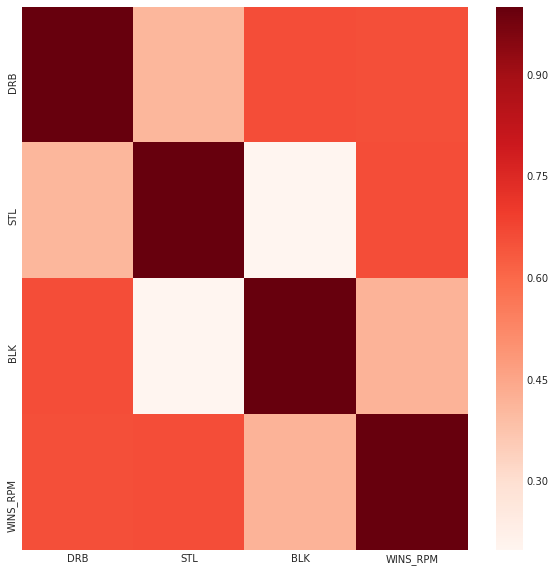

In [41]:
plt.subplots(figsize=(10,10))
sns.heatmap(player_df_def.corr(), xticklabels=player_df_def.columns.values, yticklabels=player_df_def.columns.values, cmap="Reds")

How about a covariance summary?

In [27]:
player_df_def.cov()

,DRB,STL,BLK,WINS_RPM
DRB,3.533134,0.319000,0.517600,5.195204
STL,0.319000,0.173059,0.034214,1.153166
BLK,0.517600,0.034214,0.173963,0.735968
WINS_RPM,5.195204,1.153166,0.735968,17.677302


Now let's built out a regression model, to identify the strength of this predictive model.

In [39]:
defense = smf.ols('WINS_RPM ~ DRB + STL', data=player_df_def).fit()
print(defense.summary())

                            OLS Regression Results                            
Dep. Variable:               WINS_RPM   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     189.0
Date:                Fri, 19 Jan 2018   Prob (F-statistic):           9.90e-50
Time:                        18:46:37   Log-Likelihood:                -567.59
No. Observations:                 239   AIC:                             1141.
Df Residuals:                     236   BIC:                             1152.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.5586      0.398     -8.930      0.0

Both Independent variables are reflecting a p-value < 0, and we are showing a Adjusted R-Squared value of .61.  This would generally be considered a moderate positive correlation, and is a much better indicator of predicting a player's RPM, vs overall minutes played.*

**Blocks were removed from the model, given a p-value > .05.*

Let's run some additional regression diagnostics.

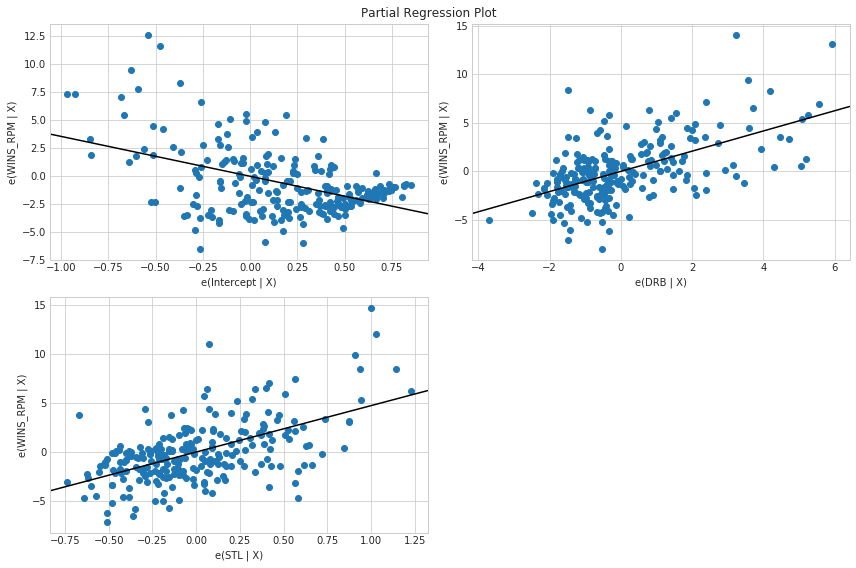

In [29]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(defense, fig=fig)

While we can still see a positive correlation between steals, defensive rebounds, and a player's RPM, is one variable more valuable than the other?

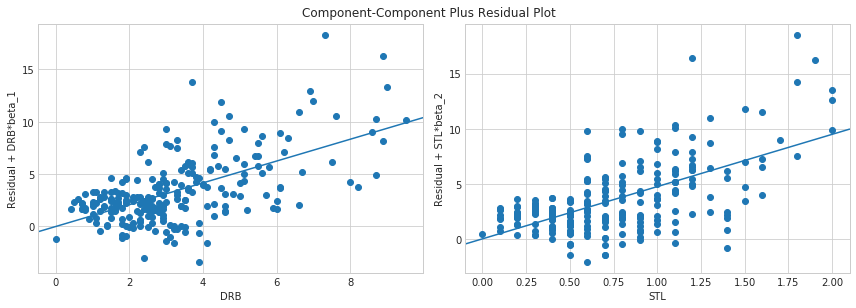

In [31]:
fig = plt.figure(figsize=(12, 8))
fig = sm.graphics.plot_ccpr_grid(defense, fig=fig)

When assessing the residual plots, there are clearly a set of values in each category that are having an effect on the relationship, but when looking for general [homoskedasticity](http://www.statsmakemecry.com/smmctheblog/confusing-stats-terms-explained-heteroscedasticity-heteroske.html) in the residual plots, steals appears to be a stronger predictor of a player's RPM.*

**Additional diagnostics can be run to further assess homoskedasticity, but for now we will assume that the variability of steals is fairly equal across the range of RPM values.*

Let's run another set of regression diagnostics, to further assess the model.

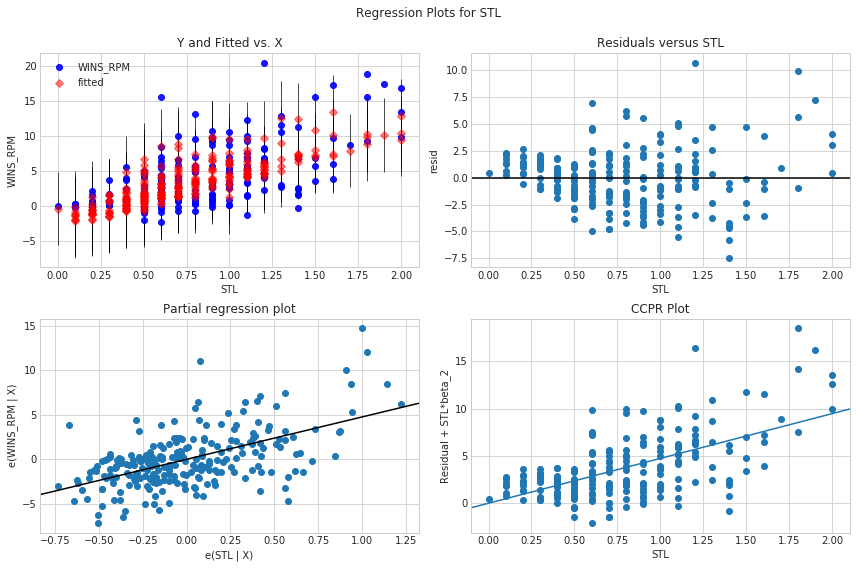

In [32]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(defense, "STL", fig=fig)

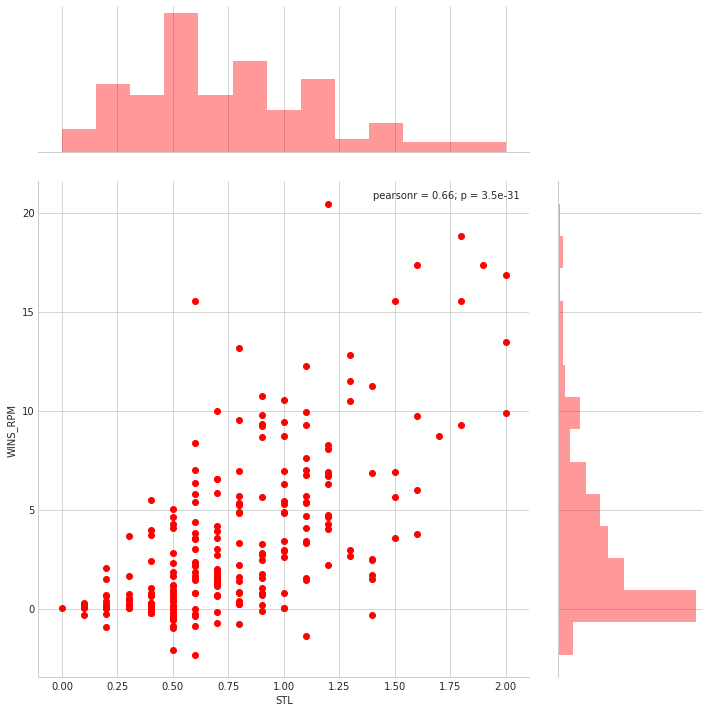

In [34]:
sns.jointplot("STL", "WINS_RPM", data=player_df_def,size=10, ratio=3, color="r")

When isolating steals as a sole predictor of a player's RPM, we can see that there is still a positive correlation.

In [37]:
steals = smf.ols('WINS_RPM ~ STL', data=player_df_def).fit()
print(steals.summary())

                            OLS Regression Results                            
Dep. Variable:               WINS_RPM   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     182.2
Date:                Fri, 19 Jan 2018   Prob (F-statistic):           3.46e-31
Time:                        18:44:18   Log-Likelihood:                -613.70
No. Observations:                 239   AIC:                             1231.
Df Residuals:                     237   BIC:                             1238.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.6215      0.428     -3.789      0.0

However, when we limit the number of independent variables in our model to only steals, we can see that our Adjusted R-Squared value drops significantly, to a weak positive correlation.

It is now safe to assume that blocks and steals combined, serve to be a better prediction of a player's RPM, relative to their defensive performance. 

***How about the offense?  Let's run through the same analysis for a player's offensive performance.***

Let's look at the correlation between offensive statistics:

In [40]:
player_df_off.corr()

,eFG,FT,ORB,AST,POINTS,WINS_RPM
eFG,1.000000,0.066847,0.354743,0.047433,0.303443,0.377955
FT,0.066847,1.000000,-0.309833,0.336495,0.416542,0.229464
ORB,0.354743,-0.309833,1.000000,-0.029561,0.255789,0.346462
AST,0.047433,0.336495,-0.029561,1.000000,0.672545,0.617456
POINTS,0.303443,0.416542,0.255789,0.672545,1.000000,0.748621
WINS_RPM,0.377955,0.229464,0.346462,0.617456,0.748621,1.000000


There does appear to be a stronger correlation between points and assists, and a player's RPM.  Now let's visualize this relationship.

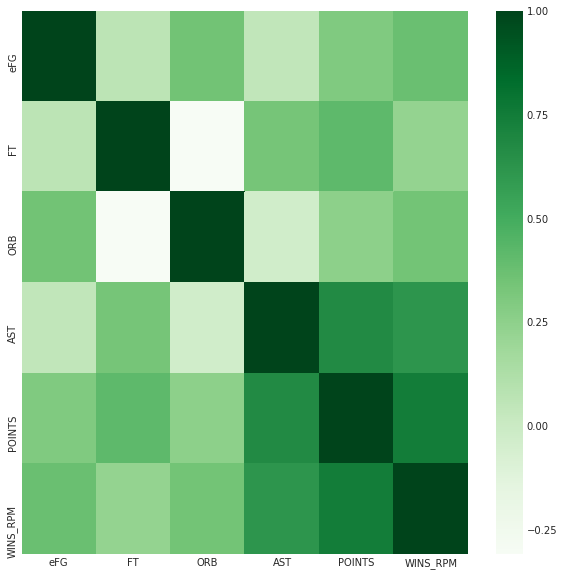

In [42]:
plt.subplots(figsize=(10,10))
sns.heatmap(player_df_off.corr(), xticklabels=player_df_off.columns.values, yticklabels=player_df_off.columns.values, cmap="Greens")

How about the covariance summary?

In [43]:
player_df_off.cov()

,eFG,FT,ORB,AST,POINTS,WINS_RPM
eFG,0.003959,0.000466,0.017873,0.006065,0.124676,0.099983
FT,0.000466,0.012275,-0.027586,0.075837,0.300822,0.107044
ORB,0.017873,-0.027586,0.641229,-0.048105,1.337572,1.166461
AST,0.006065,0.075837,-0.048105,4.129830,8.925165,5.275698
POINTS,0.124676,0.300822,1.337572,8.925165,42.643943,20.554119
WINS_RPM,0.099983,0.107044,1.166461,5.275698,20.554119,17.677302


Now let's built out a regression model, to identify the strength of this predictive model.

In [67]:
offense = smf.ols('WINS_RPM ~ eFG + ORB + AST + POINTS', data=player_df_off).fit()
print(offense.summary())

                            OLS Regression Results                            
Dep. Variable:               WINS_RPM   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     109.2
Date:                Fri, 19 Jan 2018   Prob (F-statistic):           2.34e-52
Time:                        19:21:58   Log-Likelihood:                -556.00
No. Observations:                 239   AIC:                             1122.
Df Residuals:                     234   BIC:                             1139.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.4834      1.362     -5.495      0.0

All Independent variables are reflecting a p-value < 0, and we are showing a Adjusted R-Squared value of .65.  This would generally be considered a moderate positive correlation, and is a much better indicator of predicting a player's RPM, vs overall minutes played, and slightly stronger than our deffensive model.

Let's run some additional diagnostics.

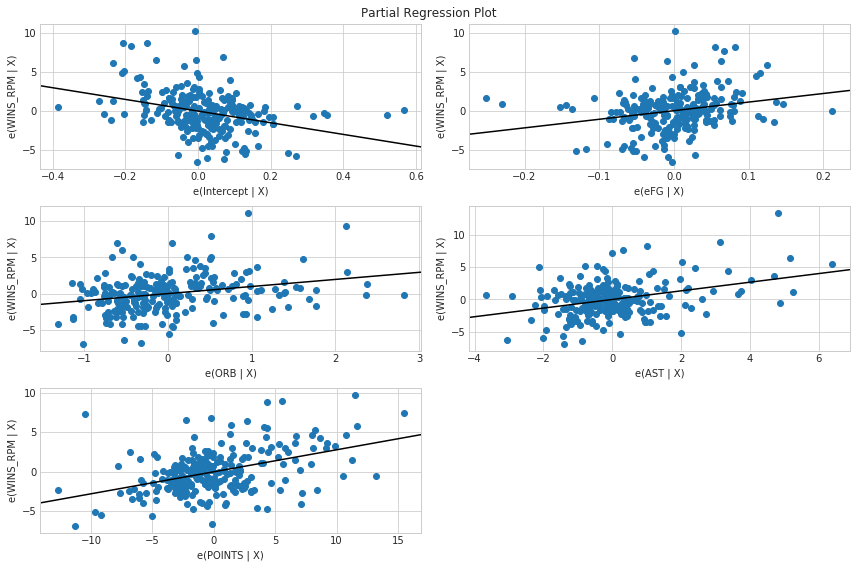

In [45]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(offense, fig=fig)

While we can still see a positive correlation between each variable and a player's RPM, is one variable more valuable than the other?

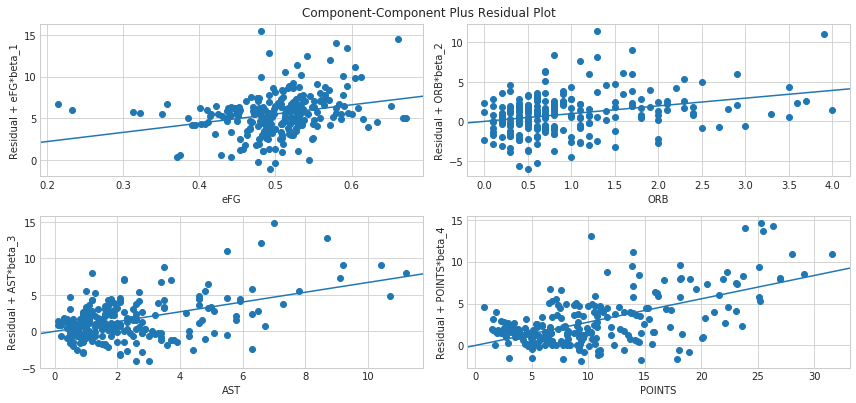

In [47]:
fig = plt.figure(figsize=(12, 8))
fig = sm.graphics.plot_ccpr_grid(offense, fig=fig)

When assessing the residual plots, there are clearly a set of values in each category that are having an effect on the relationship, but when looking for general [homoskedasticity](http://www.statsmakemecry.com/smmctheblog/confusing-stats-terms-explained-heteroscedasticity-heteroske.html) in the residual plots, points appears to be a stronger predictor of a player's RPM.*

**Additional diagnostics can be run to further assess homoskedasticity, but for now we will assume that the variability of points is fairly equal across the range of RPM values.*

Let's run another set of regression diagnostics, to further assess the model.

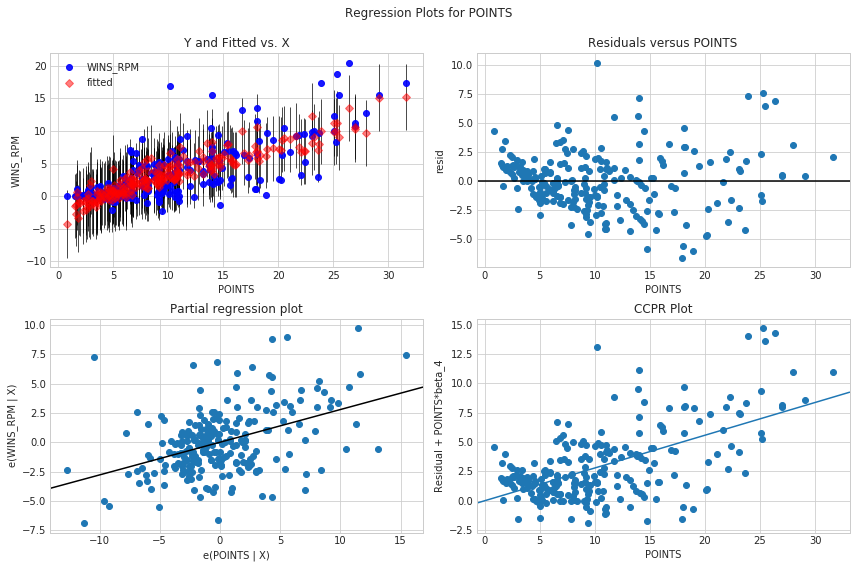

In [57]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(offense, "POINTS", fig=fig)

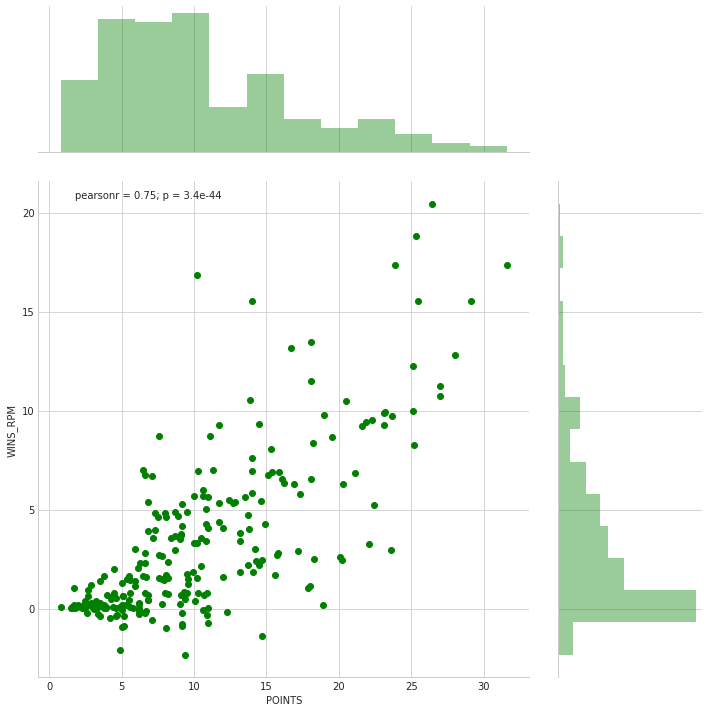

In [64]:
sns.jointplot("POINTS", "WINS_RPM", data=player_df_off,size=10, ratio=3, color="g")

When isolating points as a sole predictor of a player's RPM, we can see that there is still a positive correlation.

In [63]:
eFGs = smf.ols('WINS_RPM ~ POINTS', data=player_df_off).fit()
print(eFGs.summary())

                            OLS Regression Results                            
Dep. Variable:               WINS_RPM   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     302.2
Date:                Fri, 19 Jan 2018   Prob (F-statistic):           3.44e-44
Time:                        19:04:41   Log-Likelihood:                -583.64
No. Observations:                 239   AIC:                             1171.
Df Residuals:                     237   BIC:                             1178.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5781      0.341     -4.627      0.0

However, when we limit the number of independent variables in our model to only points, we can see that our Adjusted R-Squared value drops significantly, to a moderate positive correlation.

After removing variables from the model one by one, It is now safe to assume that all offensive variables combined, serve to be a better prediction of a player's RPM, relative to their offensive performance. 

Now let's add in all of our variables, and look at a more holistic predictive model.

In [74]:
## Final Variables
player_df_full = player_df[["PLAYER","STL","DRB","eFG%","ORB","AST","POINTS","WINS_RPM"]].copy()
player_df_full.rename(columns={'eFG%': 'eFG'}, inplace=True)
player_df_full.head()

,PLAYER,STL,DRB,eFG,ORB,AST,POINTS,WINS_RPM
0,Russell Westbrook,1.6,9.0,0.476,1.7,10.4,31.6,17.34
1,James Harden,1.5,7.0,0.525,1.2,11.2,29.1,15.54
2,Anthony Davis,1.3,9.5,0.518,2.3,2.1,28.0,12.81
3,DeMarcus Cousins,1.4,8.9,0.498,2.1,4.6,27.0,11.26
4,Damian Lillard,0.9,4.3,0.516,0.6,5.9,27.0,10.72


In [76]:
combined = smf.ols('WINS_RPM ~ STL + DRB + eFG + AST + POINTS', data=player_df_full).fit()
print(combined.summary())

                            OLS Regression Results                            
Dep. Variable:               WINS_RPM   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     112.2
Date:                Fri, 19 Jan 2018   Prob (F-statistic):           5.40e-60
Time:                        19:26:04   Log-Likelihood:                -535.36
No. Observations:                 239   AIC:                             1083.
Df Residuals:                     233   BIC:                             1104.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.1410      1.244     -6.545      0.0

The Adjusted R-Squared value in this model appears to be the strongest yet, reflecting a strong positive correlation.

**Conclusion:**

So what did we actually learn here?

We started with the baseline assumption that an individual RPM is a valid metric to assess a player's performance and contributions towards a team's victory.  When trying to understand what individual statistics help predict that RPM, we quickly passed on minutes played, and player positions.  As we began to leverage various EDA techniques, we quickly arrived a key analytical question that were aiming to solve: are defensive or offensive statistics a better predictor of a player's RPM?

We leveraged heatmaps, scatter plots, and regression modeling diagnostics to arrive at a conclusion that yield one point of view, but does warrant additional analysis.

***In essense:***

Offensive statistics are generally a better predictor of a player's RPM, than a player's deffensive statistics.  However, a combined deffensive and offensive regression model may serve as a better means of predicting a player's RPM.

An ideal player:

* A player who plays a significant amount of minutes.
* A point guard or small forward.
* A player who's defensive skills are emphasized via deffensive rebounds and steals.
* A player who's offensive skills are emphasized via an excellent effective field goal percentage, an increased frequency of assists, and a strong ability to score a lot of points.

Sounds fairly logical right?

Now you just need to find the money to pay them . . . :)
